# 3. Confidence Intervals and Limits

## Recap

We defined in Part 1 our probability model and likelihood function for a simple one bin counting experiment with $n$ events, $s$ signal and $b$ background, in our signal region and $m$ events, $b$ background, in our control region:

\begin{equation}
P(n, m; s, b) = \frac{(s+b)^n e^{-(s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(s, b),
\label{eq:model}
\end{equation}

and our test statistic $\tilde{t}_s$:

\begin{equation}
\tilde{\lambda}(s) = \left\{
    \begin{array}{ll}
      \frac{L(s, \hat{\hat{b}}(s))}{L(\hat{s}, \hat{b})}, & \mbox{$\hat{s}\geq0$}.\\
      \frac{L(s, \hat{\hat{b}}(s))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{s}<0$}.
    \end{array}
  \right., \quad \tilde{t}_s=-2\ln \tilde{\lambda}(s),
\end{equation}

and solved for $\hat{s}, \hat{b}, \hat{\hat{b}}(s)$ for given $n, m$ to find an analytic form for $t_s$.

In part 2, we translated this to a probability distribution of $\tilde{t}_s$ under a particular signal hypothesis $H_s$, and quantified the compatibility of our observation based on the $p$-value $p_s$ of the observed test statistic $\tilde{t}_s^\mathrm{obs}$:

\begin{equation}
p_s = \int_{\tilde{t}_\mathrm{obs}}^{\inf}p(\tilde{t}_s|s)\mathrm d \tilde{t}_s,
\label{eq:pvalue}
\end{equation}

and it's associated significance.

In [17]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m, b=None):
    """-2ln(lambda), b can optionally be fixed (for demo below)"""
    bhh, bh = (bhathat(s, n, m), bhat(n, m)) if b is None else (b, b)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m)
        - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()

In [18]:
def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    
    return n, m


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs

## Intervals and limits

### Confidence intervals

The machinery from Part 2 can be extended straightforwardly to extracting "confidence intervals" for our parameters of interest (POIs): a range of values of the POIs that are allowed based on the experiment, for a certain "confidence level", e.g. 68% or 95%. Very similar to the idea of the significance level, the confidence level is defined such that if we were to repeat the experiment many times, a 95%-confidence-interval must contain, or *cover*, the true value of the parameter 95% of the time. 


We can ensure this for any given confidence level (CL) by solving Eq. \ref{eq:pvalue} for a $p$-value of $1 - \mathrm{CL}$: 

\begin{equation}
p = 1 - \mathrm{CL} = \int_{\tilde{t}^\mathrm{obs}_s}^{\infty}p(\tilde{t}_s|s_\pm)\mathrm d \tilde{t}_s,
\label{eq:cl}
\end{equation}

where $s_-$ and $s_+$ are the lower and upper limits on $s$, respectively.

We can solve this by scanning $s$ and finding the values of $s$ for which the RHS $= 1 - \mathrm{CL}$. Continuing with our above example:

In [19]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2
import warnings
from IPython.display import display, Markdown

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [20]:
def get_limits(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    t_tilde_scan = []  # saving sampled test statistics for each s
    t_obs_scan = []  # saving t_obs for each s
    p_val_scan = []  # saving p-value for each s

    for s in s_scan:
        p_val, t_tilde_ss, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        t_obs_scan.append(t_obs)
        t_tilde_scan.append(t_tilde_ss)
        p_val_scan.append(p_val)

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_val_scan) - (1 - CL))
    # split into lower and upper half to get lower and upper limits
    # (not the best way to do this, but works for now...)
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]
    
    return s_low, s_high, t_tilde_scan, t_obs_scan, p_val_scan

In [21]:
num_toys = 10000
n_obs, m_obs = 20, 5
s_scan = np.arange(0, 30.1, 0.05)  # scanning s over these values
s_low, s_high, t_tilde_scan, t_obs_scan, p_val_scan = get_limits(s_scan, n_obs, m_obs, num_toys)
print(f"s-: {s_low:.1f}, s+: {s_high:.1f}")

s-: 6.0, s+: 25.4


In [22]:
def plot_2d_p_ts_s(fig, ax, t_tilde_s, s_scan, ts="t"):
    t_bins = np.linspace(0, 4, 21)
    t_tilde_hists = np.array(
        [np.histogram(t_tilde_s, t_bins)[0] / num_toys for t_tilde_s in t_tilde_scan]
    )
    mesh = ax.pcolormesh(
        t_bins,
        np.append(s_scan, 30.2),
        t_tilde_hists,
        norm=matplotlib.colors.LogNorm(),
        cmap="turbo",
    )
    ax.set_xlabel(rf"$\tilde{{{ts}}}_s$")
    ax.set_ylabel(r"$s$")
    fig.colorbar(mesh, ax=ax, label=rf"$p(\tilde{{{ts}}}_s|s)$")

    
def plot_pval_levels(ax, s_scan, t_tilde_scan, t_obs_scan, s_high, s_low=None, t_lim: float = 6.0, ts: str = "t"):
    t_vals = np.arange(0, t_lim, 0.1)
    p_vals = np.array(
        [[np.mean(t_s > t) for t in t_vals] for s, t_s in zip(s_scan, t_tilde_scan)]
    )
    clb = ax.contour(
        t_vals,
        s_scan,
        p_vals,
        levels=[0.02, 0.05, 0.1, 0.2, 0.4],
        norm=matplotlib.colors.LogNorm(vmin=1e-2, vmax=1),
        cmap="turbo",
    )
    fig.colorbar(clb, ax=ax, label=r"$p$-value")
    # plot t_obs
    ax.plot(t_obs_scan, s_scan, linestyle="--", color="red", label=rf"${ts}^\mathrm{{obs}}_s$")
    # plot s±
    if s_low is not None:
        plt.hlines(
            [s_low, s_high],
            0,
            t_lim,
            linestyle="-",
            label=r"$s_\pm$",
            color="black",
        )
    else:
        plt.hlines(
            s_high,
            0,
            t_lim,
            linestyle="-",
            label=r"$s_+$",
            color="black",
        )
    ax.set_xlabel(rf"$\tilde{{{ts}}}_s$")
    ax.set_ylabel(r"$s$")
    ax.legend()
    ax.set_xlim([0, t_lim])

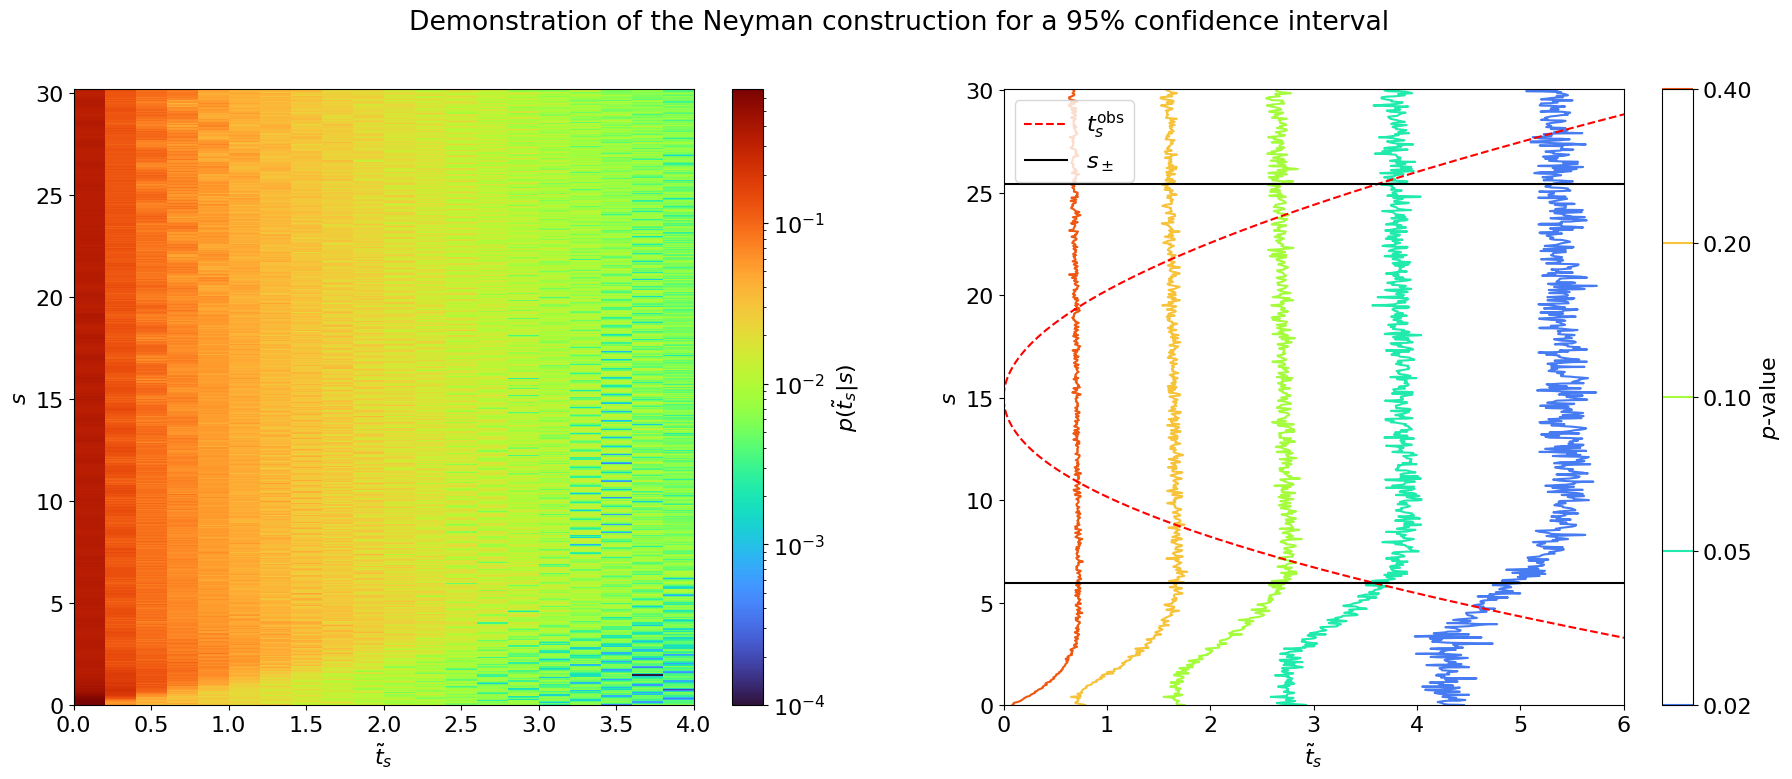

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
# plot p(t_s|s) for all values of s
plot_2d_p_ts_s(fig, axs[0], t_tilde_s, s_scan)
# plot the p-values as a function of t_s and s
plot_pval_levels(axs[1], s_scan, t_tilde_scan, t_obs_scan, s_low, s_high)
fig.suptitle("Demonstration of the Neyman construction for a 95% confidence interval")
plt.show()

Left: $p(\tilde{t}_s|s)$ for different values of $s$ \
Right: The $p$-values for different $\tilde{t}_s$'s plus $t^\mathrm{obs}_s$ in red. The points at which $t^\mathrm{obs}_s$ intersects with the $p$-value$=0.05$ contour signify the limits of the 95% confidence interval for $s: [6.0, 25.7]$.

This procedure of inverting the hypothesis test by scanning along the values of the POIs is called the "Neyman construction". One subtlety to remember is that, in principle, we should also be scanning over the nuisance parameters ($b$) when estimating the $p$-values. However, this would be very computationally expensive so in practice we continue to use $b = \hat{\hat{b}}(s)$, to always (approximately) maximise the agreement with the hypothesis. Ref. [2](#references) calls this trick "profile construction".

### Upper Limits

Typically if a search does not have enough sensitivity to directly observe a new signal, we instead quote an upper limit on the signal strength. This is similar in practice to the Neyman construction for confidence intervals, solving Eq. \ref{eq:cl} only for the upper boundary. However, when we're setting upper limits, we need to modify our test statistic, as so:

\begin{equation}
    \tilde{q}(s) = \left\{
        \begin{array}{ll}
          \tilde{t}(s), & \mbox{$\hat{s} < s$}.\\
          0, & \mbox{$\hat{s} \geq s$}.
        \end{array}
      \right.
      = \left\{
        \begin{array}{ll}
          -2\ln\tilde{\lambda}(s), & \mbox{$\hat{s} < s$}.\\
          0, & \mbox{$\hat{s} \geq s$}.
        \end{array}
      \right.
      = \left\{
      \begin{array}{ll}
          -2\ln\frac{L(s, \hat{\hat{b}}(s))}{L(0, \hat{\hat{b}}(0))}, & \mbox{$\hat{s}<0$}.\\
          -2\ln\frac{L(s, \hat{\hat{b}}(s))}{L(\hat{s}, \hat{b})}, & \mbox{0 $\leq \hat{s} < s$}.\\
          0, & \mbox{$\hat{s} \geq s$}.
        \end{array}
      \right.
\end{equation}

because we don't want $\hat{s} > s$ to indicate lower compatibility for a signal hypothesis of $s$. This is what this looks like:

In [24]:
def q_tilde_s(s, n, m):
    ts = np.array(t_s(s, n, m))
    
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    
    upper_shat_mask = shat(n, m) > s
    ts[upper_shat_mask] = 0
    
    return ts.squeeze()

In [25]:
def plot_ts_qs(ax, nms):
    s = np.linspace(0, 15, 101)
    colours = ["blue", "orange", "green"]

    for i, (n, m) in enumerate(nms):
        ax.plot(
            s,
            t_tilde_s(s, n, m),
            label=rf"$\tilde{{t}}_s$ ($n = {int(n)}, m = {int(m)}$)",
            color=colours[i],
            alpha=0.5,
        )
        ax.plot(
            s,
            q_tilde_s(s, n, m),
            label=rf"$\tilde{{q}}_s$ ($n = {int(n)}, m = {int(m)}$)",
            color=colours[i],
            linestyle="--",
            alpha=0.5
        )

    ax.set_xlabel(r"$s$")
    ax.legend()

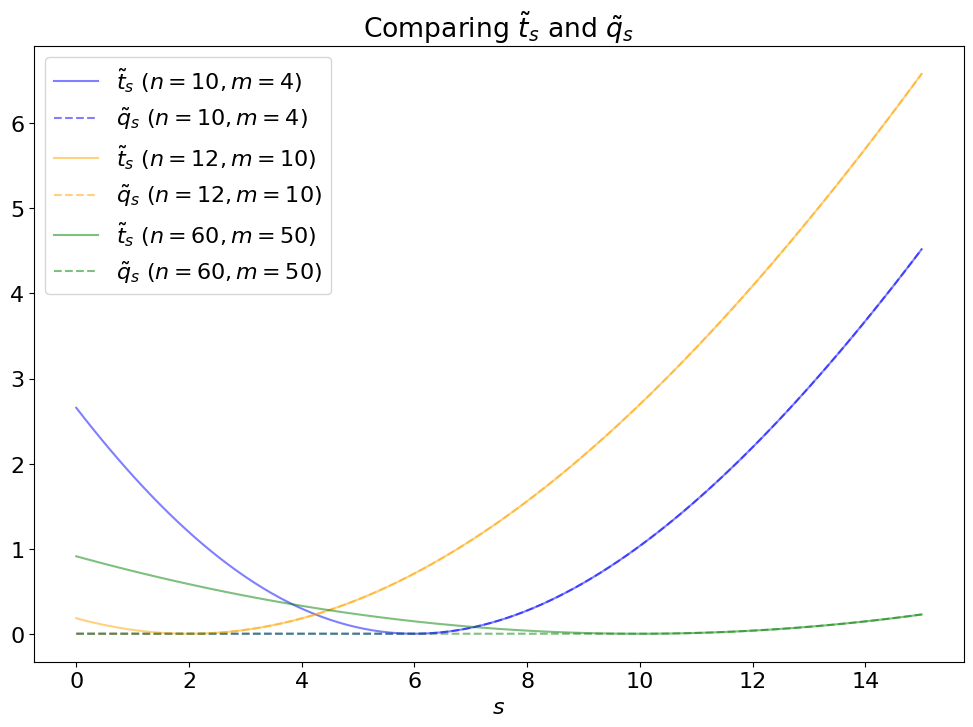

In [26]:
nms = [(10.0, 4.0), (12.0, 10.0), (60, 50.)]  # sample (n, m) observations

fig, ax = plt.subplots(figsize=(12, 8))
plot_ts_qs(ax, nms)
ax.set_title(r"Comparing $\tilde{{t}}_s$ and $\tilde{{q}}_s$")
plt.show()

As you may expect from the plot above, the distribution $p(\tilde{q}_s|s)$ no longer behaves like a standard $\chi^2$ but, instead, as a "half-$\chi^2$": essentially a $\chi^2$ + a delta function at 0 (since, under the signal hypothesis, on average there will be an over-fluctuation half the time, for which $\tilde{q}_s = 0$):

In [27]:
def plot_p_ts_qs(axs, sbs):
    xlim, bins = 6, 40

    # getting pdf of half-chi^2 distribution
    x = np.arange(0.01, xlim, 0.01)
    chi2pdf = chi2.pdf(x, 1)
    halfchi2pdf = 0.5 * chi2pdf
    halfchi2pdf[0] += (0.5 / (xlim / bins))

    for i, (s, b) in enumerate(sbs):
        # sample n, m according to our data model (Eq. 1)
        n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
        axs[i].hist(
            t_tilde_s(s, n, m),
            np.linspace(0, xlim, bins + 1),
            histtype="step",
            density=True,
            label=r"$p(\tilde{t}_s|s)$",
        )

        axs[i].hist(
            q_tilde_s(s, n, m),
            np.linspace(0, xlim, bins + 1),
            histtype="step",
            density=True,
            label=r"$p(\tilde{q}_s|s)$",
        )

        axs[i].plot(x, halfchi2pdf, label=r"half-$\chi^2_{\mathrm{DoF}=1}$")
        axs[i].legend()
        axs[i].set_title(rf"$s = {int(s)}, b = {int(b)}$")
        axs[i].set_xlabel(r"$\tilde{t}_s$ or $\tilde{q}_s$")

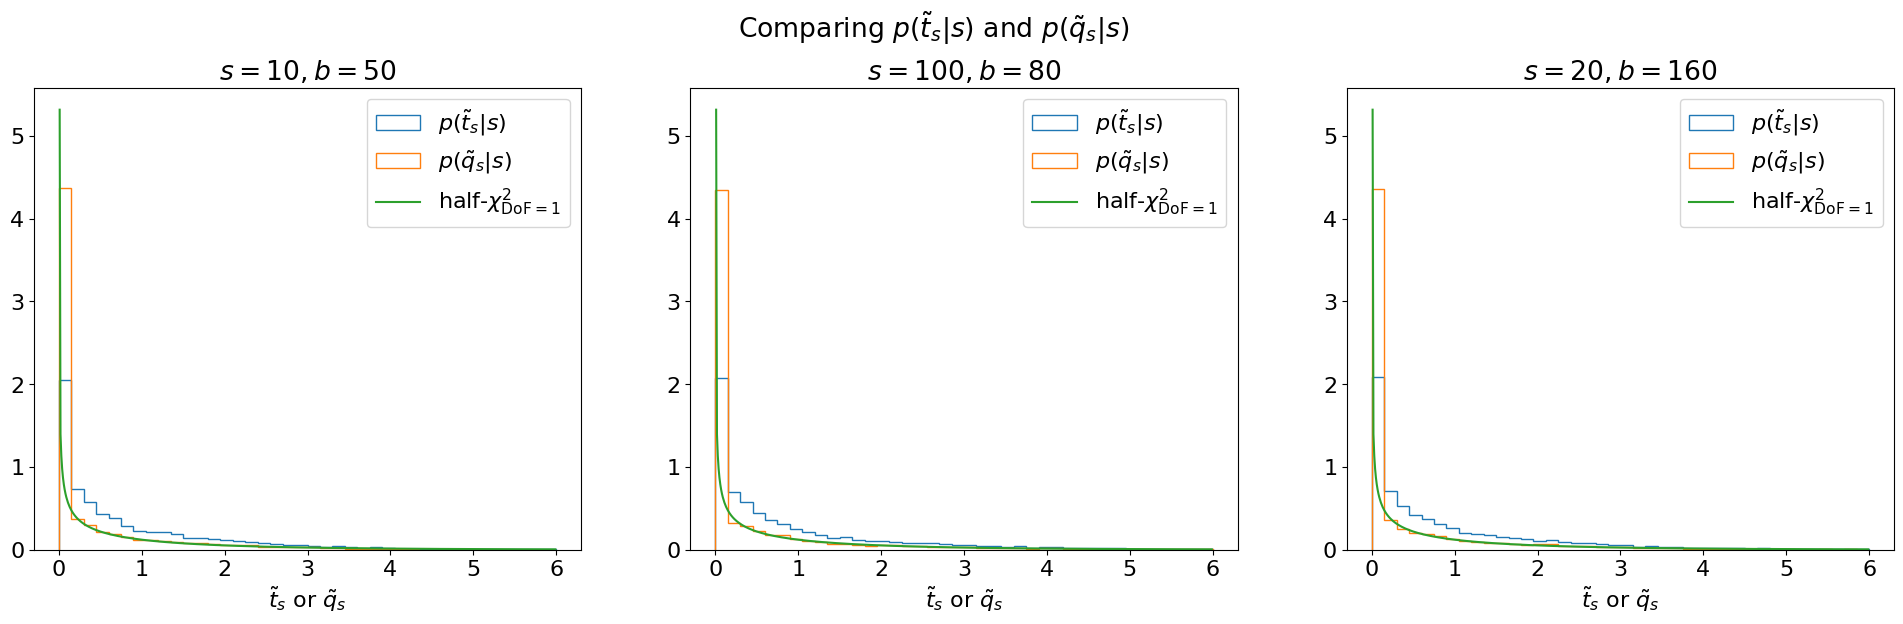

In [28]:
sbs = [(10, 50), (100, 80), (20, 160)]  # sample s, b
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plot_p_ts_qs(axs, sbs)
fig.suptitle(r"Comparing $p(\tilde{t}_s|s)$ and $p(\tilde{q}_s|s)$", y=1.01)
plt.show()

And this is what our example above looks like:

In [29]:
def get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the q_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return q_tilde_s(test_s, n, m)


def get_pval_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    q_tilde_ss = get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s)
    q_obs = q_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(q_tilde_ss > q_obs)
    return p_val, q_tilde_ss, q_obs


def get_upper_limit(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    q_tilde_scan = []  # saving sampled test statistics for each s
    q_obs_scan = []  # saving q_obs for each s
    p_val_scan = []  # saving p-value for each s

    for s in s_scan:
        p_val, q_tilde_ss, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        q_obs_scan.append(q_obs)
        q_tilde_scan.append(q_tilde_ss)
        p_val_scan.append(p_val)

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_val_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]
    
    return s_upper, q_tilde_scan, q_obs_scan, p_val_scan

In [30]:
n_obs, m_obs = 20, 5
s_scan = np.arange(0, 30.1, 0.05)  # scanning s over these values
s_upper, q_tilde_scan, q_obs_scan, p_val_scan = get_upper_limit(s_scan, n_obs, m_obs, num_toys)
print(f"s+: {s_upper:.1f}")

s+: 24.1


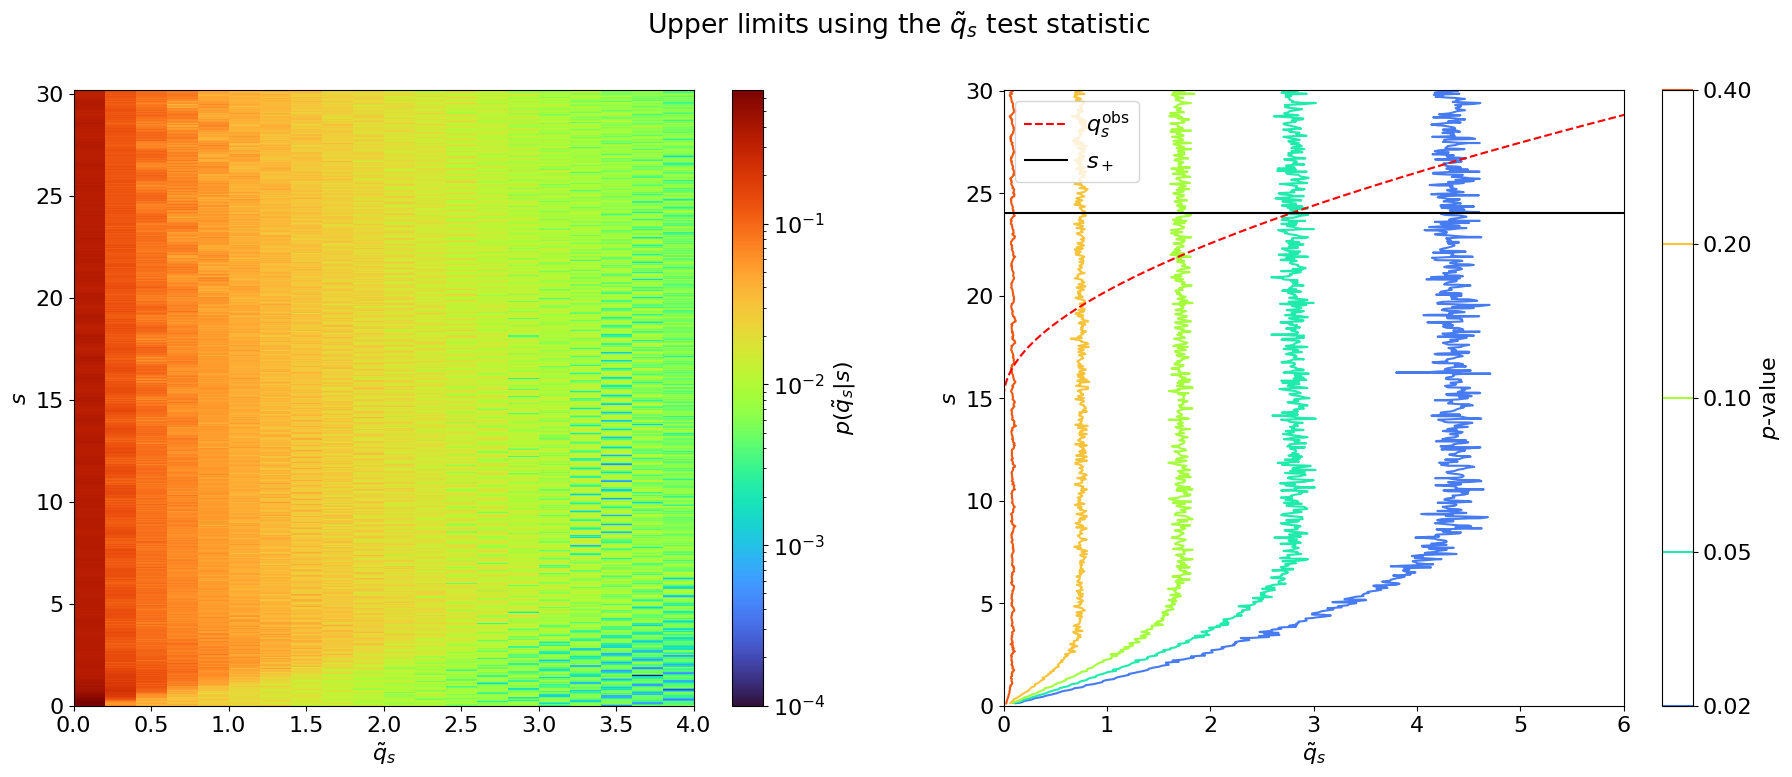

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))
# plot p(t_s|s) for all values of s
plot_2d_p_ts_s(fig, axs[0], t_tilde_s, s_scan, ts="q")
# plot the p-values as a function of t_s and s
plot_pval_levels(axs[1], s_scan, q_tilde_scan, q_obs_scan, s_upper, ts="q")
fig.suptitle(r"Upper limits using the $\tilde{q}_s$ test statistic")
plt.show()

$p(\tilde{q}_s|s)$ is shifted to the left with respect to $p(\tilde{t}_s|s)$; hence, the upper limit of 23.8 is slightly lower than the upper bound of the 95% confidence interval we derived using $\tilde{t}_s$.

### CL$_s$ method

This is a good point to introduce a few conventions related hypothesis testing and searches in particle physics. First, we usually re-parametrize our parameter of interest $s$ as:

\begin{equation}
s \rightarrow \mu \cdot s,
\end{equation}

where now $\mu$ is the parameter of interest, referred to as the "signal strength", and $s$ is a fixed value representing the number of signal events we expect to see for a signal strength $\mu$ of 1. For the example above, if we expect $s = 10$ signal events, then we could quote the upper limit as $23.8 / s = 2.38$ on $\mu$ at 95% CL.

The other convention is that we use a slightly different criteria for our confidence intervals, called "CL$_s$". This is motivated by cases where we have little sensitivity to the signal we're searching for. 
For example, let's say we expect $s = 10$ and observe $n = 50, m = 100$. This indicates that our search is not sensitive since our search region is completely dominated by background events and, hence, we should not draw strong conclusions about our signal strength from this test. However let's see what limit we set for this experiment:

In [32]:
s, n_obs, m_obs = 10, 70, 100
s_scan = np.arange(0, 10, 0.01)  # scanning s over these values
s_upper, q_tilde_scan, q_obs_scan, p_val_scan = get_upper_limit(s_scan, n_obs, m_obs, num_toys)
print(f"mu+: {s_upper / s:.2f}")

mu+: 0.04


We end up excluding the $\mu = 1$ value (at 95% CL), which is undesirable.

The idea behind CL$_s$ is to avoid this by considering both the $p$-value of the signal + background hypothesis $H_s$, referred to as $p_{s+b}$ or just $p_\mu$ for short, *and* the $p$-value of the background-only hypothesis $H_0$ ($p_b$) to define a new criterion:

\begin{equation}
p_\mu' = \cfrac{p_\mu}{1 - p_b}
\end{equation}

For cases where the signal region is completely background dominated, the compatibility with the background-only hypothesis should be high so $p_b \sim 1$ and, hence, $p_\mu'$ will be increased (as we want). On the other hand, for more sensitive regions, that compatibility should be lower and $p_b \sim 0$ and $p_\mu' \sim p_\mu$.

To be explicit,

\begin{equation}
p_b = \int^{\tilde{t}_\mathrm{obs}}_{-\infty}p(\tilde{t}_s|0)\mathrm d \tilde{t}_s.
\end{equation}

Note that: 1) we're looking at the distribution of $\tilde{t}_s$, not $\tilde{t}_0$, under the background-only hypothesis; and 2) we're integrating *up to* $\tilde{t}_\mathrm{obs}$, unlike for $p_s$, because lower $\tilde{t}$ means greater compatibility with the background-only hypothesis.

Let's see what this looks like:

In [35]:
def plot_p_ts(ax, test_s, n_obs, m_obs, t_tilde_ss, t_obs=None, p_value=None, Z=None, toy_s=None, p_s=True, hlim=6):
    if toy_s is None:
        toy_s = test_s
    
    test_s_label = "s" if test_s != 0 else "0"
    toy_s_label = "s" if toy_s != 0 else "0"
    
    h = ax.hist(
        t_tilde_ss,
        np.linspace(0, hlim, 41),
        histtype="step",
        density=True,
        label=fr"$p(\tilde{{t}}_{test_s_label}|{toy_s_label})$",
    )
    
    ylim = np.max(h[0]) * 1.1
    
    if t_obs is not None:
        ax.vlines(
            t_obs,
            0,
            ylim,
            linestyle="--",
            label=rf"$\tilde{{t}}^\mathrm{{obs}}_{test_s_label}$",
            color="red",
        )
    
    if p_value is not None:
        if p_s:
            p_label = f"$p = {p_value:.2f}$" if test_s !=0 else f"$p = {p_value:.3f}$"
            if Z is not None:
                p_label += f"\n$Z = {Z:.1f}$"

            ax.fill_between(
                x=h[1][1:],
                y1=h[0],
                where=h[1][1:] >= t_obs - 0.1,
                step="pre",
                label=p_label,
                facecolor="none",
                hatch="///",
                edgecolor="lightgreen"
            )
        else:
            p_label = f"$p_b = {p_value:.2f}$"
            ax.fill_between(
                x=h[1][:-1],
                y1=h[0],
                where=h[1][:-1] <= t_obs + 0.1,
                step="post",
                label=p_label,
                facecolor="none",
                edgecolor="lightpink",
                hatch=r"\\\\"
            )
    
    ax.set_ylim(0, ylim)
    ax.legend()
    ax.set_xlabel(rf"$\tilde{{t}}_{test_s_label}$")
    ax.set_title(
        f"$s = {int(test_s)}, n_\mathrm{{obs}} = {int(n_obs)}, m_\mathrm{{obs}} = {int(m_obs)}$"
    )

In [36]:
def plot_pmu_pb(ax, s, n_obs, m_obs, t_tilde_ss, t_tilde_sb, t_obs, p_mu, p_b, hlim=6):
    plot_p_ts(ax, s, n_obs, m_obs, t_tilde_sb, t_obs, toy_s=0, p_value=p_b, p_s=False, hlim=hlim)
    plot_p_ts(ax, s, n_obs, m_obs, t_tilde_ss, t_obs, p_value=p_mu, hlim=hlim)
    ax.plot([], [], ' ', label=f"$p_\mu' = {p_mu/(1 - p_b):.3f}$")
    handles, labels = ax.get_legend_handles_labels()
    lorder = [3, 5, 0, 2, 1, 6]
    new_handles = [handles[i] for i in lorder]
    new_labels = [labels[i] for i in lorder]
    new_labels[1] = f"$p_\mu = {p_mu:.2f}$"
    ax.legend(new_handles, new_labels)

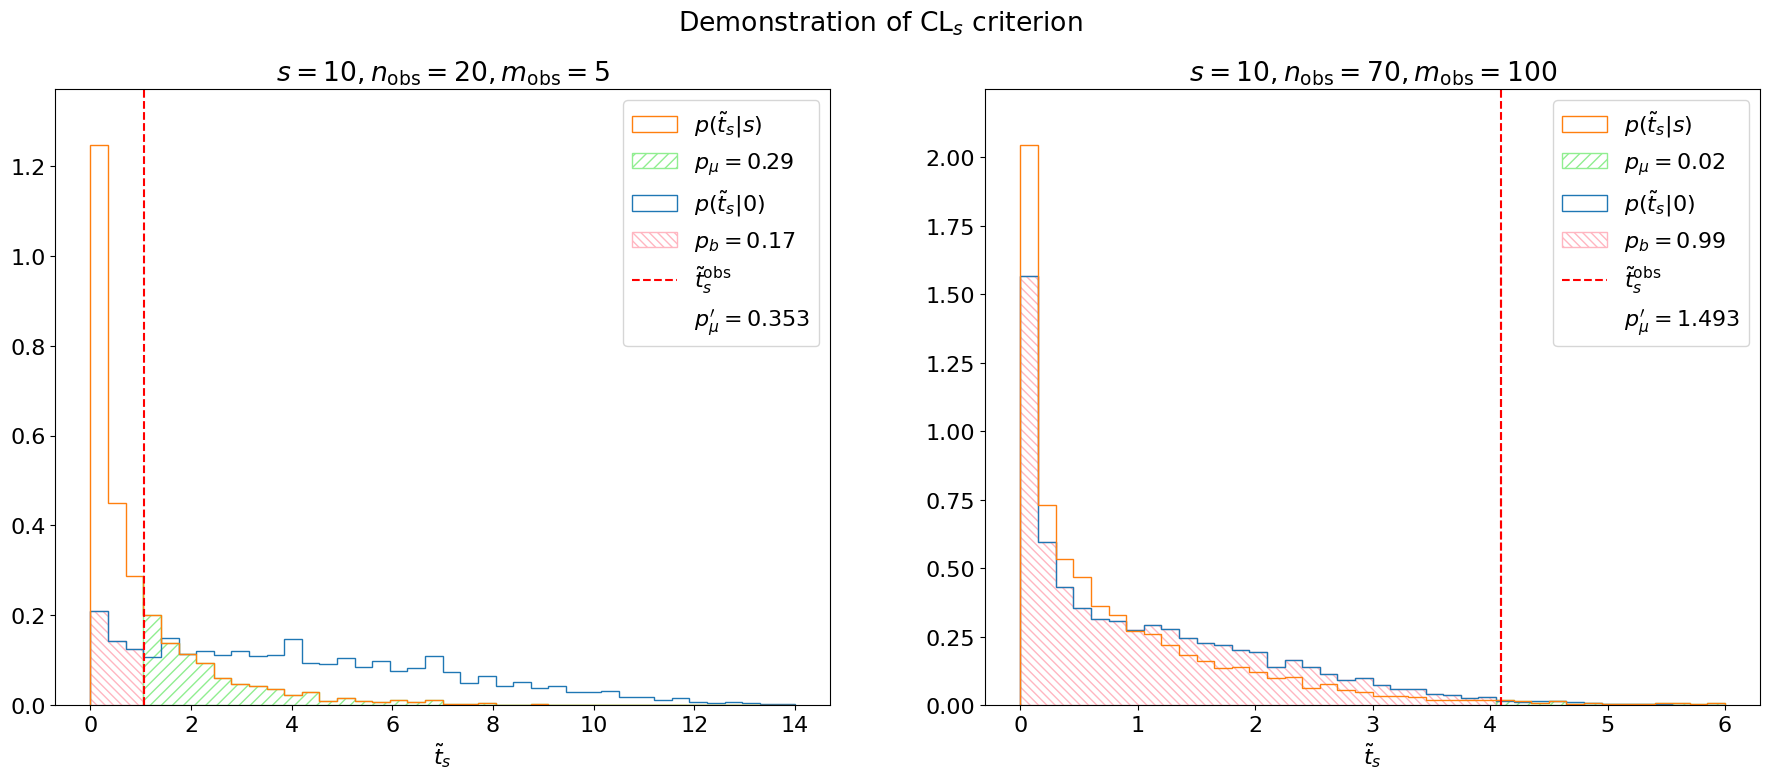

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))

s, n_obs, m_obs = 10, 20, 5
p_mu, t_tilde_ss, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
p_b, t_tilde_sb, t_obs_b = get_ps_val(s, n_obs, m_obs, num_toys, toy_s = 0)
p_b = 1 - p_b  # invert integral for background-only p_value
plot_pmu_pb(axs[0], s, n_obs, m_obs, t_tilde_ss, t_tilde_sb, t_obs, p_mu, p_b, hlim=14)

s, n_obs, m_obs = 10, 70, 100
p_mu, t_tilde_ss, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
p_b, t_tilde_sb, t_obs_b = get_ps_val(s, n_obs, m_obs, num_toys, toy_s = 0)
p_b = 1 - p_b
plot_pmu_pb(axs[1], s, n_obs, m_obs, t_tilde_ss, t_tilde_sb, t_obs, p_mu, p_b)

fig.suptitle(r"Demonstration of CL$_s$ criterion")

plt.show()

We see that for our first example (left), the background-only distribution is shifted to the right of the $s+b$ distribution, indicating higher sensitivity, and thus $p_\mu' \sim p_\mu$. In the second example, however, the search is not very sensitive and, hence, the background-only and $s+b$ distributions almost completely overlap $\Rightarrow p_b \sim 1$ and $p_\mu' >> p_\mu$. Note also that, unlike $p(\tilde{t}_s|s)$, $p(\tilde{t}_s|0)$ *doesn't* follow a simple $\chi^2$; asymptotically, it is closer to a *noncentral $\chi^2$*, as discussed in Ref. [1](#references), and which we'll get to in Part 3.

Finally, let's see if our upper limit make more sense using CL$_s$:

In [38]:
def get_limits_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        p_b, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]
    
    return s_low, s_high


def get_upper_limit_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        p_b, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]
    
    return s_upper

In [39]:
s, n_obs, m_obs = 10, 70, 100
s_scan = np.arange(0, 30, 0.1)  # scanning s over these values
s_upper = get_upper_limit_CLs(s_scan, n_obs, m_obs, num_toys)
print(f"mu+: {s_upper / s:.1f}")

mu+: 1.0


Indeed, we see a looser, more conservative, upper limit. We can also confirm that the limit for our first example, which had better sensitivity, stay about the same:

In [40]:
n_obs, m_obs = 20, 5
s_scan = np.arange(0, 30.1, 0.05)  # scanning s over these values
s_upper = get_upper_limit_CLs(s_scan, n_obs, m_obs, num_toys)
print(f"mu+: {s_upper / s:.1f}")

mu+: 2.4


## Summary

We extended the framework for hypothesis testing to derive frequentist confidence intervals for parameters of interest by solving for particular $p$-values, called the "Neyman construction". For upper limits, we find that we need to use a further modified test statistic $\tilde{q}_\mu$ and the "CL$_s$" method to avoid excluding signals for which we don't have sensitivity. In Part 4, I'll discuss the concepts of *expected* significances and limits, which are important to estimate our experiment's sensitivity before collecting or looking at the data.

## References

[1] Cowan, Cranmer, Gross, and Vitells, *Asymptotic formulae for likelihood-based tests of new physics* (2010) [arxiv:1007.1727](https://arxiv.org/abs/1007.1727v3) \
[2] Cranmer, *Practical Statistics for the LHC* (2015) [arxiv:1503.07622](https://arxiv.org/abs/1503.07622)